# Machine Learning

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
from xgboost import XGBClassifier
from keras import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics, tree
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, auc

In [39]:
df = pd.read_csv('../dataset/df_tratado.csv')
df_ml = pd.read_csv('../dataset/df_ml.csv')
df_ml.head()

,id,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,promoção,pg
0,1,M,Palmas,laptop_básico,2300.0,73,0,1
1,2,F,Palmas,laptop_básico,2300.0,51,1,1
2,3,M,Salvador,cadeira,540.0,61,1,1
3,4,M,Belo_Horizonte,laptop_básico,2300.0,81,0,0
4,5,M,Palmas,mouse,20.0,82,0,1


### Normalização

In [5]:
df_ml['produto_valor'] =  df_ml['produto_valor']/df_ml['produto_valor'].max()
df_ml['cliente_idade'] = df_ml['cliente_idade']/df_ml['cliente_idade'].max()
df_ml.head()

,id,cliente_sexo,loja_cidade,produto_produto,produto_valor,cliente_idade,promoção,pg
0,1,M,Palmas,laptop_básico,0.433962,0.829545,0,1
1,2,F,Palmas,laptop_básico,0.433962,0.579545,1,1
2,3,M,Salvador,cadeira,0.101887,0.693182,1,1
3,4,M,Belo_Horizonte,laptop_básico,0.433962,0.920455,0,0
4,5,M,Palmas,mouse,0.003774,0.931818,0,1


### Dados categoricos

In [11]:
col_cat = ['cliente_sexo', 'loja_cidade', 'produto_produto', 'promoção']
df_ml_dummies = pd.get_dummies(df_ml[col_cat].astype(str), drop_first=False, dtype=int)
df_ml_dummies.head()

,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo_Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,loja_cidade_Recife,loja_cidade_Rio_de_Janeiro,loja_cidade_Salvador,...,produto_produto_impressora,produto_produto_laptop_básico,produto_produto_laptop_gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx_231a,promoção_0,promoção_1
0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [12]:
df_ml = pd.concat([df_ml, df_ml_dummies], axis=1)
df_ml = df_ml.drop(col_cat, axis=1)
df_ml.head()

,id,produto_valor,cliente_idade,pg,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo_Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,...,produto_produto_impressora,produto_produto_laptop_básico,produto_produto_laptop_gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx_231a,promoção_0,promoção_1
0,1,0.433962,0.829545,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,2,0.433962,0.579545,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,3,0.101887,0.693182,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,0.433962,0.920455,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,5,0.003774,0.931818,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


## Dados de treinamento e de teste

In [31]:
y = df_ml.pg
X = df_ml.drop(['pg'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_new = X.loc[[3, 4]]
X_new

,id,produto_valor,cliente_idade,cliente_sexo_F,cliente_sexo_M,cliente_sexo_O,loja_cidade_Belo_Horizonte,loja_cidade_Brasília,loja_cidade_Curitiba,loja_cidade_Palmas,...,produto_produto_impressora,produto_produto_laptop_básico,produto_produto_laptop_gamer,produto_produto_mesa,produto_produto_monitor,produto_produto_mouse,produto_produto_teclado,produto_produto_xxx_231a,promoção_0,promoção_1
3,4,0.433962,0.920455,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,5,0.003774,0.931818,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


### Regressão logística

In [19]:
# Resumo do modelo de RL
all_col_with_plus = ' + '.join(df_ml.drop(['pg'], axis=1).columns)
modelo = smf.glm(formula='pg ~ ' + all_col_with_plus, data=df_ml,
                family = sm.families.Binomial()).fit()
print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     pg   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2976
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1338.0
Date:                Sun, 22 Oct 2023   Deviance:                       2675.9
Time:                        11:01:15   Pearson chi2:                 3.01e+03
No. Iterations:                    17   Pseudo R-squ. (CS):             0.2919
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

P > 0,05 é significativo para o estudo

In [20]:
model = LogisticRegression(penalty='none', solver='newton-cg')
model.fit(X_train, y_train)

print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

- Matriz de Confusão
[[181 114]
 [ 76 529]]

- Reporte completo
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       928
           1       0.84      0.88      0.86      2072

    accuracy                           0.80      3000
   macro avg       0.77      0.75      0.76      3000
weighted avg       0.79      0.80      0.80      3000


- Reporte teste
              precision    recall  f1-score   support

           0       0.70      0.61      0.66       295
           1       0.82      0.87      0.85       605

    accuracy                           0.79       900
   macro avg       0.76      0.74      0.75       900
weighted avg       0.78      0.79      0.78       900



C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [32]:
model.predict(X_new)

array([1, 1], dtype=int64)

O modelo deveria prever [0,1] para este caso específico

### Arvore de Decisão

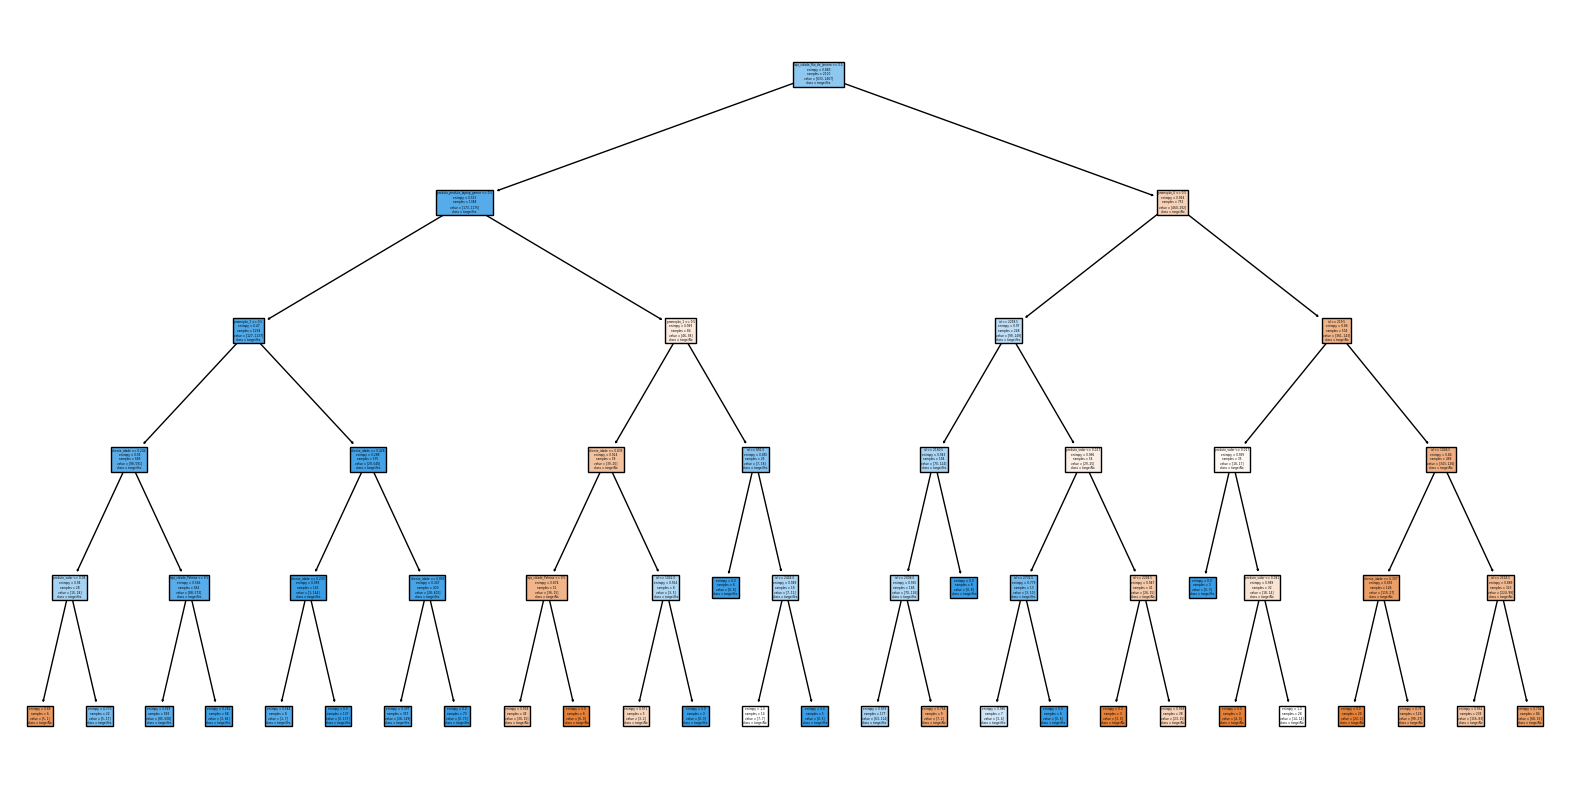

In [36]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model = model.fit(X_train,y_train)
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(model, 
                   feature_names=X.columns,  
                   class_names=['targetNo','targetYes'],
                   filled=True)

In [37]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

- Matriz de Confusão
[[198  97]
 [ 97 508]]

- Reporte completo
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       928
           1       0.86      0.87      0.86      2072

    accuracy                           0.81      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.81      0.81      0.81      3000


- Reporte teste
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       295
           1       0.84      0.84      0.84       605

    accuracy                           0.78       900
   macro avg       0.76      0.76      0.76       900
weighted avg       0.78      0.78      0.78       900



In [40]:
df.loc[X_new.index]
model.predict(X_new)

array([1, 1], dtype=int64)

In [41]:
df.loc[X_new.index]

,id,id_cliente,id_loja,id_produto,dt_venda,cliente_nome,cliente_sexo,cliente_dt_nasc,loja_cidade,produto_produto,produto_valor,dt_pgto,pg,tempo_pg,cliente_idade
3,4,59,4,3,2018-01-05,Rodrigo Ribeiro,M,1941-11-05,Belo Horizonte,laptop básico,2300.0,NaN,0,NaN,81
4,5,18,9,1,2018-01-05,Antônio Azevedo,M,1941-04-15,Palmas,mouse,20.0,2018-01-23,1,18.0,82


O modelo deveria prever [0,1] para este caso

### Redes Neurais

In [63]:
tensorflow.random.set_seed(2)

model = Sequential()
model.add(Dense(15, activation='relu', kernel_initializer='random_normal', input_dim=len(X.columns)))
model.add(Dense(7, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(3, activation='relu', kernel_initializer='random_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [64]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=128, epochs=300, verbose=False)

In [65]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype("int32")))
print('\n- Reporte completo')
print(classification_report(y, (model.predict(X) > 0.5).astype("int32")))
print('\n- Reporte teste')
print(classification_report(y_test, (model.predict(X_test) > 0.5).astype("int32")))

- Matriz de Confusão
29/29 [==============================] - 0s 884us/step
[[  0 295]
 [  0 605]]

- Reporte completo
94/94 [==============================] - 0s 837us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       928
           1       0.69      1.00      0.82      2072

    accuracy                           0.69      3000
   macro avg       0.35      0.50      0.41      3000
weighted avg       0.48      0.69      0.56      3000


- Reporte teste
29/29 [==============================] - 0s 838us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       295
           1       0.67      1.00      0.80       605

    accuracy                           0.67       900
   macro avg       0.34      0.50      0.40       900
weighted avg       0.45      0.67      0.54       900



C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

In [66]:
model.predict(X_new)

1/1 [==============================] - 0s 31ms/step


array([[0.6988257],
       [0.6988257]], dtype=float32)

O modelo deveria prever [0,1] para este caso

### GGBoost

In [68]:
model = XGBClassifier()
model.fit(X_train, y_train)

C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categoric

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [69]:
print('- Matriz de Confusão')
print(confusion_matrix(y_test, model.predict(X_test)))
print('\n- Reporte completo')
print(classification_report(y, model.predict(X)))
print('\n- Reporte teste')
print(classification_report(y_test, model.predict(X_test)))

- Matriz de Confusão
[[166 129]
 [ 88 517]]

- Reporte completo
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       928
           1       0.93      0.95      0.94      2072

    accuracy                           0.91      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.91      0.91      0.91      3000


- Reporte teste
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       295
           1       0.80      0.85      0.83       605

    accuracy                           0.76       900
   macro avg       0.73      0.71      0.72       900
weighted avg       0.75      0.76      0.75       900



C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categoric

In [70]:
model.predict(X_new)

C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categoric

array([0, 1])

O modelo deveria prever [0,1] para este caso